In [1]:
# Model
from source.custom.models.CustomBERTopic import CustomBERTopic

# Metrics
from octis.evaluation_metrics.diversity_metrics import TopicDiversity
from octis.evaluation_metrics.coherence_metrics import Coherence

# Dataset
from octis.dataset.dataset import Dataset

# Useful libraries
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch


In [2]:
datasets = [
    ('datasets/pec_471_2005/', 'PEC 471/2005'),
    ('datasets/pl_3723_2019/', 'PL 3723/2019')
]


In [3]:
sberts = [
    ('sberts/ulysses_sbert_random_double_aka_650k_nheeng/pytorch_model.bin', '650K'),
    ('sberts/ulysses_sbert_map2doc_v1/pytorch_model.bin', 'MAP2DOC'),
    ('sberts/ulysses_sbert_triplets/pytorch_model.bin', 'Triplets'),
    ('sberts/ulysses_sbert_1mil_anama/pytorch_model.bin', '1MIL'),
    ('sberts/ulysses_sbert_lr56/pytorch_model.bin', 'LR56'),
    (None, 'LaBSE'),
    (None, 'all-MiniLM-L6-v2')
]


In [4]:
def load_sbert(sbert):
    """
    Load the SentenceBERT model
    :param sbert_path: path to the SentenceBERT model
    :return: SentenceBERT model
    """

    if (sbert[1] == 'all-MiniLM-L6-v2'):
        return None

    if (sbert[1] == 'LaBSE'):
        return SentenceTransformer('sentence-transformers/LaBSE', device='cpu')

    else:
        return torch.load(sbert[0], torch.device('cuda'))


In [5]:
def eval_sbert(dataset_path, sbert):
    """
    Evaluate a BERTopic model using SBERT embeddings given a dataset path and a SBERT model path.

    Parameters
    ----------
    dataset_path : path to the dataset
    sbert_path : path to the SBERT model

    Returns
    -------
    coherence_results : coherence results
    diversity_results : diversity results
    """

    dataset = Dataset()
    dataset.load_custom_dataset_from_folder(dataset_path)

    bertopic = CustomBERTopic(
        embedding_model=sbert
    )

    results = bertopic.train_model(dataset)

    coherence = Coherence(texts=dataset.get_corpus())
    diversity = TopicDiversity()

    coherence_results = coherence.score(results)
    diversity_results = diversity.score(results)

    return coherence_results, diversity_results


In [6]:
results = pd.DataFrame(
    columns=[
        'Dataset',
        'SBERT',
        'Coherence',
        'Diversity',
        'Iter']
)


In [7]:
for dataset in datasets:
    for sbert in sberts:
        for it in range(10):
            coherence, diversity = eval_sbert(dataset[0], load_sbert(sbert))
            results = results.append(
                {'Dataset': dataset[1],
                 'SBERT': sbert[1],
                 'Coherence': coherence,
                 'Diversity': diversity,
                 'Iter': it},
                ignore_index=True)


In [8]:
mean_results = pd.DataFrame(results.groupby(['Dataset', 'SBERT']).mean()).reset_index()
mean_results

,Dataset,SBERT,Coherence,Diversity
0,PEC 471/2005,1MIL,-0.103193,0.954286
1,PEC 471/2005,650K,-0.096343,0.975000
2,PEC 471/2005,LR56,-0.092633,0.950714
3,PEC 471/2005,LaBSE,-0.072696,0.977778
4,PEC 471/2005,MAP2DOC,-0.066800,0.980000
5,PEC 471/2005,Triplets,-0.140963,0.965000
6,PEC 471/2005,all-MiniLM-L6-v2,-0.105632,0.642571
7,PL 3723/2019,1MIL,-0.063294,0.753030
8,PL 3723/2019,650K,-0.065032,0.708998
9,PL 3723/2019,LR56,-0.069264,0.750691


In [9]:
sns.set(style="darkgrid")
sns.set_context("paper")
plt.rcParams["font.size"] = 8


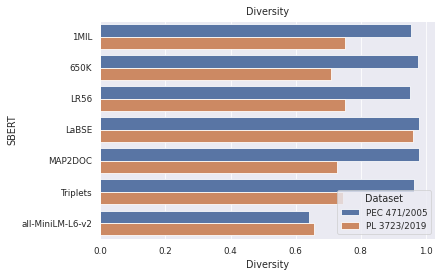

In [10]:
plt.title("Diversity")
ax = sns.barplot(x=mean_results['Diversity'], y=mean_results['SBERT'], hue=mean_results['Dataset'], orient='h')
plt.savefig('plots/diversity.svg', format='svg', dpi=1200, bbox_inches='tight')

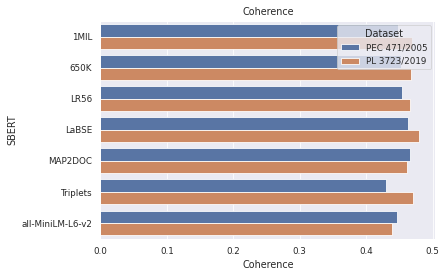

In [11]:
plt.title("Coherence")
sns.barplot(x=(mean_results['Coherence'] + 1) / 2, y=mean_results['SBERT'], hue=mean_results['Dataset'], orient='h')
plt.savefig('plots/coherence.svg', format='svg', dpi=1200, bbox_inches='tight')